# CLINT WP5 063: DEBUGGING Outgoing Longwave Radiation

Checking out while the plots for OLR have problems with the dates

### 2023/11/17

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import netCDF4 as nc
from datetime import datetime as dt
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy
import importlib
import seaborn as sns
import os
import time
import matplotlib.ticker as mticker

from cdo import *
cdo = Cdo()

import CLINT001_functions as clint
importlib.reload(clint)

<module 'CLINT001_functions' from '/home/b/b382649/CLINT_WP5/CLINT001_functions.py'>

In [2]:
## DIRECTORIES
machine = 'DKRZ'
kind = 'ERA5' #ERA5 or hist
experiment = 5


if machine == 'laptop':
    modeldir = '~/Documents/CMCC-GoogleDrive/ERA5/'
    metadatadir = '~/Library/Mobile\ Documents/com~apple~CloudDocs/CLINT/metadata/'
    maskdir = '~/Documents/CMCC-GoogleDrive/Mask_Clusters/Test3_Clusters/'
    plotdir = '/Users/squintu/Documents/CMCC-GoogleDrive/plots_for_reports/'
    
if machine == 'workstation':
    modeldir = '~/Documents/CMCC-GoogleDrive/ERA5/'
    metadatadir = '~/Library/Mobile\ Documents/com~apple~CloudDocs/CLINT/metadata/'
    maskdir = '~/Documents/CMCC-GoogleDrive/Mask_Clusters/Test3_Clusters/'
    plotdir = '/Users/antonellosquintu/Documents/CMCC-GoogleDrive/plots_for_reports/'

if machine == 'juno':
    repodir = '/home/b/b382649/CLINT_WP5'
    obsdir = repodir
    modeldir = f'/work/csp/as18623/CLINT_{kind}/'
    workmetadir = '/work/csp/as18623/CLINT_metadata/'
    metadatadir = '/data/csp/as18623/CLINT_metadata/'
    maskdir = '/data/csp/as18623/CLINT_metadata/Masks/Test3_Clusters/'
    plotdir = '/work/csp/as18623/CLINT_WP5/maps_and_plots/'
    
if machine == 'DKRZ':
    if kind == 'ERA5':
        modeldir1 = f"/work/bm1159/XCES/data4xces/reanalysis/reanalysis/ECMWF/IFS/ERA5/day/atmos/" #where are the model data?    
        workdir = "/work/bk1318/b382649/ERA5/"
    obsdir = '/home/b/b382649/CLINT_WP5/obs/'    
    workmetadir = '/home/b/b382649/CLINT_WP5/metadata/'
    metadatadir = '/home/b/b382649/CLINT_WP5/metadata/'
    maskdir = '/home/b/b382649/CLINT_WP5/Mask_Clusters/' #not necessary anymore
    plotdir = '/work/csp/as18623/CLINT_WP5/maps_and_plots/' #not plotting at the momenbt

In [3]:
modelspecs = pd.DataFrame({'kind':['ERA5','hist'],
                           'modelnames':['era5','CMCC-CM2-SR5'],#name of models
                           'members_list':[np.nan,np.array(range(3,12))]})#list of member numbers)

modelspecs = pd.DataFrame({'kind':['ERA5','hist'],
                           'model_names':['era5','CMCC-CM2-SR5'],#name of models
                           'members_list':[[1],[2]],
                           'model_path':["/work/bm1159/XCES/data4xces/reanalysis/reanalysis/ECMWF/IFS/ERA5/",
                                          np.nan],
                            'work_path':["/work/bk1318/b382649/ERA5/",np.nan]})#list of member numbers)


In [4]:
modelspecs.model_path.values

array(['/work/bm1159/XCES/data4xces/reanalysis/reanalysis/ECMWF/IFS/ERA5/',
       nan], dtype=object)

In [5]:
varspecs = pd.read_csv(f'{workmetadir}variables_specifications.csv')

In [6]:
## Open land-sea mask and round to integer
## The mask has values between 0 and 1 according to the proportion of the grid-point
##  which is covered by land
## Any gridpoint with more than 0.5 is rounded to 1 and considered land

lsm = xr.open_dataset(f'{metadatadir}/era5_lsm.nc').round()

In [7]:
### Read series of tmax and HWMI related to Lake Como
lchw = pd.read_csv(f'{obsdir}/LakeComo_tmax_HW.csv',index_col='date')

In [8]:
### Identify 2019 heat wave

row_maxHWMI = lchw.loc[lchw['Valle_HWintensity'].idxmax()]
date2019_dt = dt.strptime(row_maxHWMI.name,"%Y-%m-%d")
date2019_ts = pd.to_datetime(date2019_dt)

In [9]:
### Identify dates
date_aux_dt = dt.strptime(lchw.loc[lchw.year==1983]['Valle_HWintensity'].idxmax(),"%Y-%m-%d")
date_aux_ts = pd.to_datetime(date_aux_dt)

In [10]:
variables = ['olr']


In [11]:
## indicate the date of the events and the variables to be included

dates_ts = (pd.to_datetime("2022-07-22"), 
            pd.to_datetime("2019-06-27"), 
            pd.to_datetime("2003-08-11"), 
            pd.to_datetime("1983-07-21"))

## don't run too many dates at once otherwise the notebook won't open next time

dates_ts =[pd.to_datetime("2003-08-11")]
if kind == 'ERA5':
    houroffset = 0 #daily files of era5 are labeled with 00 UTC
else:
    houroffset = 12 #daily files of CMIP6 are labeled with 12 UTC

dates_ts1 = dates_ts
dates_ts = [d + pd.DateOffset(hours = houroffset) for d in dates_ts1]





In [12]:
drivers = pd.read_csv(f'{workmetadir}drivers{experiment}_Test.csv')
drivers

,var,era5cds_var,era5cmor_var,cmip6_var,unit,exp,exp_size,domain,cl_nr,cl_name,...,cl_ext_S,cl_ext_N,vmin,vmax,text_plot_lon,text_plot_lat,fig_width,ax_width,ax_height,empty
0,tmax,NaN,tasmax,tasmax,°C,5.0,low,Europe,1.0,cl5low_Europe1_tmax,...,42.0,58.0,-15.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN
1,tmax,NaN,tasmax,tasmax,°C,5.0,low,Europe,2.0,cl5low_Europe2_tmax,...,39.0,63.5,-15.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN
2,mslp,NaN,psl,psl,hPa,5.0,low,Europe,3.0,cl5low_Europe3_mslp,...,57.0,71.0,-250.0,250.0,NaN,NaN,NaN,NaN,NaN,NaN
3,mslp,NaN,psl,psl,hPa,5.0,low,World,2.0,cl5low_World2_mslp,...,-76.0,-46.5,-250.0,250.0,NaN,NaN,NaN,NaN,NaN,NaN
4,sm,NaN,swvl1,mrsos,m^3/m^3,5.0,low,Europe,1.0,cl5low_Europe1_sm,...,42.0,62.0,-0.2,0.2,NaN,NaN,NaN,NaN,NaN,NaN
5,sm,NaN,swvl1,mrsos,m^3/m^3,5.0,low,Europe,2.0,cl5low_Europe2_sm,...,29.0,71.0,-0.2,0.2,NaN,NaN,NaN,NaN,NaN,NaN
6,sm,NaN,swvl1,mrsos,m^3/m^3,5.0,low,Europe,5.0,cl5low_Europe5_sm,...,34.0,51.0,-0.2,0.2,NaN,NaN,NaN,NaN,NaN,NaN
7,z500,z500,zg,zg,m,5.0,low,Europe,4.0,cl5low_Europe4_z500,...,29.0,55.0,-400.0,400.0,NaN,NaN,NaN,NaN,NaN,NaN
8,z500,z500,zg,zg,m,5.0,low,Europe,5.0,cl5low_Europe5_z500,...,44.5,60.5,-400.0,400.0,NaN,NaN,NaN,NaN,NaN,NaN
9,tp,tp,pr,pr,mm/day,5.0,low,Europe,1.0,cl5low_Europe1_tp,...,44.5,68.5,-5.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
importlib.reload(clint)
varspecs = pd.read_csv(f'{workmetadir}variables_specifications.csv')
drivers = pd.read_csv(f'{workmetadir}drivers{experiment}_Test.csv')
tstart = time.time()

In [14]:
modelspecs

,kind,model_names,members_list,model_path,work_path
0,ERA5,era5,[1],/work/bm1159/XCES/data4xces/reanalysis/reanaly...,/work/bk1318/b382649/ERA5/
1,hist,CMCC-CM2-SR5,[2],NaN,NaN


### Lines from clint.loop_map_grids

(drivers, dates_ts, variables, lsm, modelspecs1, varspecs, machine, workdir, modeldir, maskdir, plotdir)
(drivers, dates_ts, variables, lsm, modelspecs, varspecs,  machine, workdir, modeldir1, maskdir, plotdir)

In [15]:
modelspecs1 = modelspecs[modelspecs.kind == kind]
modeldir = modeldir1
date_ts = dates_ts[0]
var = variables[0]

In [16]:
y = date_ts.year

In [17]:
varrow = varspecs.loc[varspecs['var'] == var]
drivers_sub = drivers.loc[drivers['var'] == var]
#print(varrow)
if kind == 'ERA5':
    #datasetnames = ['era5']
    if machine == 'DKRZ':
        kind_var = 'era5cmor_var'
    else:
        kind_var = 'era5cds_var'
    kind_aggr = 'era5_aggr'
    #if machine == 'DKRZ':
    #    datapaths = sum([[f"{modeldir1}{varrow[kind_aggr][0]}/atmos/{nc_var}/{mmbname}/" for mmb in modelrow["members_list"]] for i, modelrow in modelspecs1.iterrows()],[])
    experiment = 'era5'
    product = 'reanalysis'
    tres = varrow['era5_aggr'].values[0]
    year_start = 1981
    year_stop = 2010

else:
    #[print(modelrow) for i, modelrow in modelspecs.iterrows()]
    datapaths = sum([[f'{modelrow["modelnames"]}-{kind}-r{mmb}' for mmb in modelrow["members_list"]] for i, modelrow in modelspecs1.iterrows()],[])
    kind_var = 'cmip6_var'
    kind_aggr = 'cmip6_aggr'

#print(kind_var)
#print(varrow)
nc_var = varrow[kind_var].values[0]
aggr_operator = varrow['aggr_operator'].values[0]


models = modelspecs1.loc[modelspecs1.kind == kind,'model_names'].to_list()


In [18]:
mdl = models[0]

In [19]:
mdl = models[0]
modelpath = modelspecs1.loc[modelspecs1['model_names']==mdl,'model_path'].values[0]
workpath = modelspecs1.loc[modelspecs1['model_names']==mdl,'work_path'].values[0]
members = modelspecs1.loc[modelspecs1['model_names']==mdl,'members_list'].values[0]


In [20]:
mmb = members[0]

In [21]:
if var == 'z500':
    mmbname = f'r{mmb}i1p1-050000Pa'
else:
    mmbname = f'r{mmb}i1p1'

mmbpath = f"{modelpath}{tres}/{varrow['realm'].values[0]}/{nc_var}/{mmbname}/"

## If daily anomalies are not available, get them
if not os.path.exists(f'{workpath}{nc_var}_dailyanom_{product}_{experiment}_{mmbname}_{y}0101-{y}1231.nc'):
    get_anom_w_cdo(nc_var, y, kind, year_start, year_stop, aggr_operator, tres, product,experiment,mmbname, mmbpath, workpath) 

anom_xr = xr.open_dataset(f'{workpath}/{nc_var}_dailyanom_{product}_{experiment}_{mmbname}_{y}0101-{y}1231.nc')
anom_xr = anom_xr.convert_calendar('gregorian') #convert to gregorian calendar
#anom_xr['time'] = anom_xr.indexes['time'].normalize() #drop hour from time axis

if ((np.max(anom_xr.lon)>180) |
   (np.min(anom_xr.lon)<180)):
    anom_xr = clint.rearrange_lon (anom_xr)

dims = list(anom_xr.dims)

if (('longitude' in dims) | ('latitude' in dims)):
    infile = f'{workpath}/{nc_var}_dailyanom_{product}_{experiment}_{mmbname}_{y}0101-{y}1231.nc'
    outfile = f'{workpath}/{nc_var}_dailyanom_{product}_{experiment}_{mmbname}_{y}0101-{y}1231.nc'
    command = f'cdo chname,longitude,lon {infile} {outfile}'

    infile = f'{workpath}/{nc_var}_dailyanom_{product}_{experiment}_{mmbname}_{y}0101-{y}1231.nc'
    outfile  = f'{workpath}/{nc_var}_dailyanom_{product}_{experiment}_{mmbname}_{y}0101-{y}1231.nc'
    command = f'cdo chname,latitude,lat {infile} {outfile}'

    anom_xr = xr.open_dataset(f'{workpath}/{nc_var}_dailyanom_{product}_{experiment}_{mmbname}_{y}0101-{y}1231.nc')
    anom_xr = anom_xr.convert_calendar('gregorian')

    if np.max(anom_xr.lon)>180:
        anom_xr = clint.rearrange_lon (anom_xr)  

if var == 'mslp': #conversion from Pa to hPa
    anom_xr[nc_var] = anom_xr[nc_var]/100

if var == 'tp': #conversion from kg/(m^2*s) to mm
    anom_xr[nc_var] = anom_xr[nc_var]*86400


In [22]:
drivers_row = drivers_sub.iloc[1]

In [23]:
drivers_row

var                                  olr
era5cds_var                          olr
era5cmor_var                        rlut
cmip6_var                           rlut
unit                               W/m^2
exp                                  5.0
exp_size                             low
domain                             World
cl_nr                                3.0
cl_name                cl5low_World3_olr
cl_code                              NaN
cl_info                              NaN
clmask_path           Test5low_Clusters/
clmask_file        labels11olrWorld5.csv
minlag                              25.0
maxlag                              51.0
cl_centroid_lon                      NaN
cl_centroid_lat                      NaN
cl_ortho_lon                     -173.25
cl_ortho_lat                   -3.041688
cl_ext_W                           152.0
cl_ext_E                          -138.5
cl_ext_S                           -13.5
cl_ext_N                             8.5
vmin            

In [24]:
mask_df = pd.read_csv(f"{maskdir}{drivers_row['clmask_path']}{drivers_row['clmask_file']}",index_col=[0])
cl_nr = drivers_row['cl_nr']
submask = mask_df[mask_df.cluster == cl_nr-1] #python indexing, cluster 1 is nr0 in the mask file...
maskedanom = clint.mask_xr_w_df(var, anom_xr, submask, lsm, kind)


In [25]:
np.unique(submask.loc[(mask_df['cluster']==2) & (abs(mask_df['nodes_lon'])<50),'nodes_lat'])

array([], dtype=float64)

In [26]:
coarsemask = submask.assign(flag=1).set_index(["nodes_lon", "nodes_lat"]).flag.to_xarray().fillna(0).rename({"nodes_lon": 'lon', "nodes_lat": 'lat'})

In [27]:
mask_df[mask_df['nodes_lon']>178]

,cluster,nodes_lat,nodes_lon


In [28]:
gg = submask.assign(flag=1).set_index(["nodes_lon", "nodes_lat"]).flag
l0 = gg.index.get_level_values(0)
l1 = gg.index.get_level_values(1)
cond = (l0 > 178) 
gg[cond]

np.unique(l0)

array([-180. , -179.5, -179. , -178.5, -178. , -177.5, -177. , -176.5,
       -176. , -175.5, -175. , -174.5, -174. , -173.5, -173. , -172.5,
       -172. , -171.5, -171. , -170.5, -170. , -169.5, -169. , -168.5,
       -168. , -167.5, -167. , -166.5, -166. , -165.5, -165. , -164.5,
       -164. , -163.5, -163. , -162.5, -162. , -161.5, -161. , -160.5,
       -160. , -159.5, -159. , -158.5, -158. , -157.5, -157. , -156.5,
       -156. , -155.5, -155. , -154.5, -154. , -153.5, -153. , -152.5,
       -152. , -151.5, -151. , -150.5, -150. , -149.5, -149. , -148.5,
       -148. , -147.5, -147. , -146.5, -146. , -145.5, -145. , -144.5,
       -144. , -143.5, -143. , -142.5, -142. , -141.5, -141. , -140.5,
       -140. , -139.5,  153. ,  153.5,  154. ,  154.5,  155. ,  155.5,
        156. ,  156.5,  157. ,  157.5,  158. ,  158.5,  159. ,  159.5,
        160. ,  160.5,  161. ,  161.5,  162. ,  162.5,  163. ,  163.5,
        164. ,  164.5,  165. ,  165.5,  166. ,  166.5,  167. ,  167.5,
      

In [30]:
hh=submask.assign(flag=1).set_index(["nodes_lon", "nodes_lat"]).flag.to_xarray()


In [31]:
hh['nodes_lon']

<xarray.DataArray 'nodes_lon' (nodes_lon: 133)>
array([-180. , -179.5, -179. , -178.5, -178. , -177.5, -177. , -176.5, -176. ,
       -175.5, -175. , -174.5, -174. , -173.5, -173. , -172.5, -172. , -171.5,
       -171. , -170.5, -170. , -169.5, -169. , -168.5, -168. , -167.5, -167. ,
       -166.5, -166. , -165.5, -165. , -164.5, -164. , -163.5, -163. , -162.5,
       -162. , -161.5, -161. , -160.5, -160. , -159.5, -159. , -158.5, -158. ,
       -157.5, -157. , -156.5, -156. , -155.5, -155. , -154.5, -154. , -153.5,
       -153. , -152.5, -152. , -151.5, -151. , -150.5, -150. , -149.5, -149. ,
       -148.5, -148. , -147.5, -147. , -146.5, -146. , -145.5, -145. , -144.5,
       -144. , -143.5, -143. , -142.5, -142. , -141.5, -141. , -140.5, -140. ,
       -139.5,  153. ,  153.5,  154. ,  154.5,  155. ,  155.5,  156. ,  156.5,
        157. ,  157.5,  158. ,  158.5,  159. ,  159.5,  160. ,  160.5,  161. ,
        161.5,  162. ,  162.5,  163. ,  163.5,  164. ,  164.5,  165. ,  165.5,
        166. ,  166.5,  167. ,  167.5,  168. ,  168.5,  169. ,  169.5,  170. ,
        170.5,  171. ,  171.5,  172. ,  172.5,  173. ,  173.5,  174. ,  174.5,
        175. ,  175.5,  176. ,  176.5,  177. ,  177.5,  178. ])
Coordinates:
  * nodes_lon  (nodes_lon) float64 -180.0 -179.5 -179.0 ... 177.0 177.5 178.0

### why all Nan
During the application of mask_xr_w_df the values are all modified to Nan, why?

(var, anom_xr, submask, lsm, kind)
(var, xrdf, submask, lsm, kind)

In [32]:
xrdf = anom_xr

In [33]:
## Generate coordinates of all gridpoints around the 2x2
exp_list = [clint.expand_res_grid(row) for index,row in submask.iterrows()] 

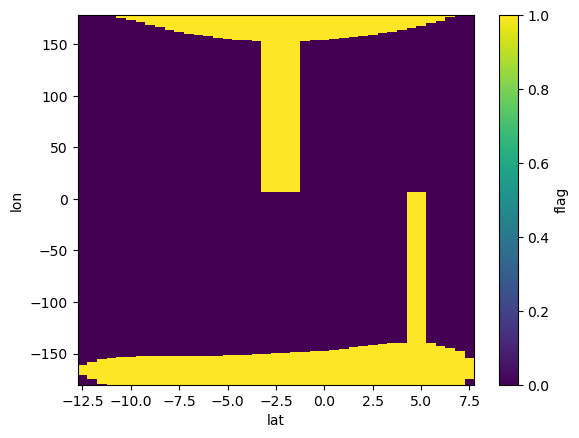

In [34]:
coarsemask.plot()

In [35]:
## Concatenate dataframes with all the new gridpoints
exp_df = pd.concat(exp_list,ignore_index=True).reset_index(drop=True)
exp_df['cluster'] = np.nanmean(submask['cluster']) #add the missing column so that it can be merged to submask
## Append the new gridpoints to the original 2x2 mask
submask_exp = pd.concat([submask,exp_df],ignore_index=True).drop_duplicates().reset_index(drop=True)

In [36]:
submask_exp = submask_exp.loc[submask_exp['nodes_lon']>=-180]

In [39]:
## If data between 178E and 180E are forgotten, add them manually
add_list = [clint.new_gps_cdl(submask_exp,nlat) for nlat in np.unique(submask_exp['nodes_lat'])]
add_list = [i for i in add_list if i is not None]

,nodes_lat,nodes_lon
0,178.50,-11.25
1,178.75,-11.25
2,179.00,-11.25
3,179.25,-11.25
4,179.50,-11.25
...,...,...
433,178.75,6.75
434,179.00,6.75
435,179.25,6.75
436,179.50,6.75


In [49]:
if len(add_list)>0:
    print('Integrate across the date change line')
    add_df = pd.concat(add_list,ignore_index=True).reset_index(drop=True)
    add_df['cluster'] = cl_nr-2
    submask_exp = pd.concat([submask_exp,add_df],ignore_index=True).reset_index(drop=True)

Integrate across the date change line


In [50]:
add_df

,nodes_lat,nodes_lon,cluster
0,178.50,-11.25,1.0
1,178.75,-11.25,1.0
2,179.00,-11.25,1.0
3,179.25,-11.25,1.0
4,179.50,-11.25,1.0
...,...,...,...
433,178.75,6.75,1.0
434,179.00,6.75,1.0
435,179.25,6.75,1.0
436,179.50,6.75,1.0


In [52]:
submask_exp.loc[submask_exp['nodes_lon']>178]

,cluster,nodes_lat,nodes_lon
4454,2.0,6.25,178.25
4455,2.0,6.50,178.25
4457,2.0,6.75,178.25
4743,2.0,5.75,178.25
4744,2.0,6.00,178.25
...,...,...,...
14734,2.0,-10.00,178.25
14909,2.0,-10.75,178.25
14910,2.0,-10.50,178.25
15066,2.0,-11.25,178.25


In [343]:
mask = submask_exp.assign(flag=1).set_index(["nodes_lon", "nodes_lat"]).flag.to_xarray().fillna(0).rename({"nodes_lon": 'lon', "nodes_lat": 'lat'})

In [344]:
mask1 = mask.interp(lon=xrdf['lon'], 
                    lat=xrdf['lat'], 
                    method="nearest")
mask1 = mask1.fillna(0)


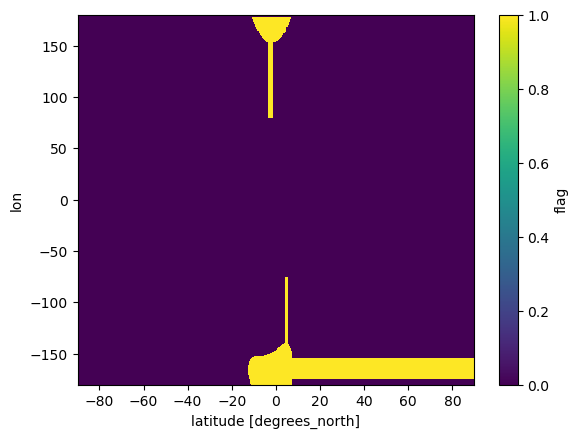

In [351]:
mask1.plot()

### lines from multimaps_lag 
(xrdf = maskedanom, targetdate_ts = date_ts,drivers_row = drivers_row, kind=kind, machine=machine, plotdir = plotdir, #submask_df,proj = 'Ortographic',vmin='drivers', vmax='drivers')
(xrdf, targetdate_ts, drivers_row, kind, machine, plotdir,# submask_df,
                   proj='Ortographic', vmin='drivers', vmax='drivers')

In [353]:
xrdf = maskedanom
targetdate_ts = date_ts
proj = 'Ortographic'
vmin = 'drivers'
vmax = 'drivers'

In [354]:
polar = False
var = drivers_row['var']
cl_name = drivers_row['cl_name']

minlag = int(drivers_row['minlag'])
maxlag = int(drivers_row['maxlag'])

fig_width = drivers_row['fig_width']
if np.isnan(fig_width):
    fig_width = 48

## VALUES THAT DEPEND ON THE VARIABLE

if vmin == 'drivers':
    vmin = drivers_row['vmin']
if vmax == 'drivers':
    vmax = drivers_row['vmax']
    var = drivers_row['var']

if np.isnan(vmin):
    vmin = None
if np.isnan(vmax):
    vmax = None

if kind == 'ERA5':
    if machine == 'DKRZ':
        nc_var = drivers_row.era5cmor_var
    else:
        nc_var = drivers_row.era5
elif kind == 'hist':
    nc_var = drivers_row.cmip6_var


palette = clint.palette_CLINT(var)       


## DEFINE PROJECTION AND MAP EXTENT

my_projn = ccrs.Orthographic(central_longitude=drivers_row['cl_ortho_lon'],
                             central_latitude=drivers_row['cl_ortho_lat'])
lonlatproj = ccrs.PlateCarree()
# These chunk, first takes the limits of the box then calculates the coordinated in the projection
# In the last line, the extreme coordinates in the new reference are identified
# These extremes are give to set_extent()
SW_lon, SW_lat = my_projn.transform_point(drivers_row['cl_ext_W']-1, 
                                        drivers_row['cl_ext_S']-1, 
                                        lonlatproj)  #(0.0, -3189068.5)
NE_lon, NE_lat = my_projn.transform_point(drivers_row['cl_ext_E']+1, 
                                        drivers_row['cl_ext_N']+1, 
                                        lonlatproj) #(3189068.5, 0)
NW_lon, NW_lat = my_projn.transform_point(drivers_row['cl_ext_W']-1, 
                                        drivers_row['cl_ext_N']+1, 
                                        lonlatproj)  #(0.0, -3189068.5)
SE_lon, SE_lat = my_projn.transform_point(drivers_row['cl_ext_E']+1, 
                                        drivers_row['cl_ext_S']-1, 
                                        lonlatproj) #(3189068.5, 0)
SC_lon, SC_lat = my_projn.transform_point(drivers_row['cl_ortho_lon'], 
                                        drivers_row['cl_ext_S']-1, 
                                        lonlatproj) #(3189068.5, 0)
NC_lon, NC_lat = my_projn.transform_point(drivers_row['cl_ortho_lon'], 
                                        drivers_row['cl_ext_N']+1, 
                                        lonlatproj) #(3189068.5, 0)
xmin,xmax,ymin,ymax = min(SW_lon,NW_lon), max(NE_lon,SE_lon), min(SW_lat,SE_lat,SC_lat), max(NE_lat,NW_lat, NC_lat)


numfigs = len(range(minlag,maxlag+1)) ## number of figures depends on how many days
numfigs_h = np.floor((12000000/(xmax-xmin)+3)/2) ## number of figures per row depends on the size of the cluster
numfigs_v = np.ceil(numfigs/numfigs_h) ## number of rows is calculated by consequence

map_ratio = (xmax-xmin)/(ymax-ymin) ## width divided by height

if (abs(drivers_row['cl_ortho_lat'])>=80):
    print('switch to polar view')
    polar = True
    numfigs_h = 3
    numfigs_v = np.ceil(numfigs/numfigs_h)
    map_ratio = 1.1


This variable does not have a customized palette


In [355]:
print([xmin,xmax,ymin,ymax])   
## DEFINE SIZE OF SUBPLOTS



ax_width = drivers_row['ax_width']
if np.isnan(ax_width):        
    ax_width = (fig_width)/numfigs_h    

ax_height = drivers_row['ax_height']
if np.isnan(ax_height):
    ax_height = ax_width/map_ratio

## DEFINE WHERE TO WRITE THE LAG    

text_plot_lon = drivers_row['text_plot_lon']
if np.isnan(text_plot_lon):
    text_plot_lon = drivers_row['cl_ext_E']-2

text_plot_lat = drivers_row['text_plot_lat']
if np.isnan(text_plot_lat):
    text_plot_lat = drivers_row['cl_ext_N']-2

[nan, nan, nan, nan]


In [356]:
## IDENTIFY THE DATES

targetdate_str = dt.strftime(targetdate_ts,'%Y-%m-%d %H')

y = targetdate_ts.year
m = str(targetdate_ts.month).zfill(2)
d = str(targetdate_ts.day).zfill(2)

In [357]:
targetdate_ts

Timestamp('2003-08-11 00:00:00')

In [358]:
xrdf['time'] = xrdf.indexes['time'].normalize()

In [359]:
# Determine extremes of the date range considered, in the netcdf every day has 12:00 as hour
mintime_ts = targetdate_ts - pd.DateOffset(days = maxlag) + pd.DateOffset(hours = 12)
maxtime_ts = targetdate_ts - pd.DateOffset(days = minlag) + pd.DateOffset(hours = 12)

mintime_str = dt.strftime(mintime_ts,'%Y-%m-%d')
maxtime_str = dt.strftime(mintime_ts,'%Y-%m-%d')

targetdate_str = dt.strftime(targetdate_ts,'%Y-%m-%d')
h_offset = pd.to_datetime(xrdf.isel(time=0)['time'].values).hour #what is the hour of data in the netcdf
m_offset = pd.to_datetime(xrdf.isel(time=0)['time'].values).minute #what is the hour of data in the netcdf

In [360]:
f=0
lag = minlag

In [361]:
plotdate_ts = targetdate_ts - pd.DateOffset(days = lag) + pd.DateOffset(hours = h_offset) + pd.DateOffset(minutes = m_offset)
#print(plotdate_ts)

In [362]:
xrdf['time']

<xarray.DataArray 'time' (time: 366)>
array(['2003-01-01T00:00:00.000000000', '2003-01-02T00:00:00.000000000',
       '2003-01-03T00:00:00.000000000', ..., '2003-12-30T00:00:00.000000000',
       '2003-12-31T00:00:00.000000000', '2004-01-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2003-01-01 2003-01-02 ... 2004-01-01

In [363]:
sub1d = xrdf.sel(time=plotdate_ts)

In [364]:
sub1d

<xarray.Dataset>
Dimensions:    (bnds: 2, lon: 1280, lat: 640)
Coordinates:
    time       datetime64[ns] 2003-07-17
  * lon        (lon) float64 -180.0 -179.7 -179.4 -179.2 ... 179.2 179.4 179.7
  * lat        (lat) float64 89.78 89.51 89.23 88.95 ... -89.23 -89.51 -89.78
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (bnds, lon, lat) datetime64[ns] NaT NaT NaT NaT ... NaT NaT NaT
    lon_bnds   (lon, bnds, lat) float64 nan nan nan nan nan ... nan nan nan nan
    lat_bnds   (lat, bnds, lon) float64 nan nan nan nan nan ... nan nan nan nan
    rlut       (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    CDI:            Climate Data Interface version 2.2.1 (https://mpimet.mpg....
    Conventions:    CF-1.6
    institution:    European Centre for Medium-Range Weather Forecasts
    tracking_id:    d5b13485-16f3-5f65-8dfd-cf03615bcc01
    creation_date:  2022-09-07T17:51:34Z
    license:        Contains modified Copernicus Atmosphere Monitoring Servic...
    NCO:            netCDF Operators version 5.0.6 (Homepage = http://nco.sf....
    history:        Fri Nov 17 11:53:33 2023: cdo -b 32 -ydaysub /work/bk1318...
    frequency:      day
    CDO:            Climate Data Operators version 2.2.0 (https://mpimet.mpg....

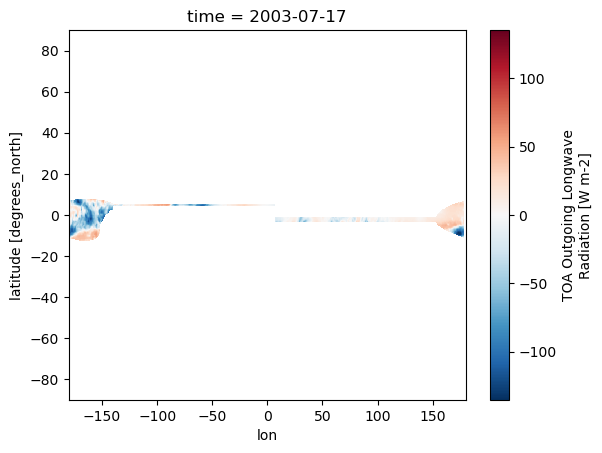

In [365]:
sub1d['rlut'].plot()

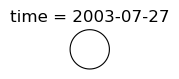

In [366]:
fig, axs = plt.subplots(int(numfigs_v), int(numfigs_h),
                        subplot_kw={'projection': lonlatproj},
                        figsize=(fig_width,int(numfigs_v*ax_height)),
                        sharey=True,sharex=True)#,
                        #layout="constrained")
fig.suptitle(f'{var}, {minlag} to {maxlag} days before {targetdate_str}', fontsize = 100)
axs = axs.flatten()  
axs[f].remove()
geo_axes = plt.subplot(int(numfigs_v), int(numfigs_h), f+1,
                       projection=my_projn)

#print(sub1d.variables)

cs=sub1d[nc_var].plot(ax=geo_axes,transform=ccrs.PlateCarree(),cmap=palette, 
                   vmin = vmin, vmax = vmax, add_colorbar=False)
geo_axes.coastlines()

geo_axes.add_feature(cartopy.feature.BORDERS, linestyle='-', alpha=.5)
#geo_axes.text(x=text_plot_lon, y=text_plot_lat, 
#              s=f'-{lag}d', transform=ccrs.PlateCarree(), fontsize=70)
geo_axes.text(x=0.875, y=0.9, horizontalalignment='center', verticalalignment='center',
              s=f'-{lag}d', transform=geo_axes.transAxes, fontsize=70)
if not polar:
    geo_axes.set_extent([xmin,xmax,ymin,ymax], crs=my_projn) # data/projection coordinates 
#print(f'before this, {f}')
else:
     geo_axes.set_extent([-180, 180, drivers_row['cl_ext_S']-1 , 90], crs=lonlatproj)
gl = geo_axes.gridlines(lonlatproj,linewidth=2, color='lightgray', alpha=0.5)
gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, 5))
gl.ylocator = mticker.FixedLocator(np.arange(-90, 90, 5))


plt.title(None)

ValueError: cannot convert float NaN to integer